# Ranking on undirected graphs

Here we check the ranking for undirected graphs, such as, the path graphs, cycle graphs, star graphs, wheel graphs, comlete graph, balanced tree, and barbell graph. 

## Programs

These programs are collected from the file "Ranking on nodes directed graph with damping factor.ipynb". Check that file for detailed description.

In [2]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd

In [3]:
pi = np.pi

In [4]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

In [5]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [6]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

In [7]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

In [8]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

In [9]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

In [10]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

In [11]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

In [12]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

In [13]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

In [14]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = np.real(Q[i])
    return(dic, t)

In [15]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

In [16]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = np.around(v[i], 4)
    return(dic, t)
#     return(v)

In [17]:
def find_ranks_of_vertices(P):
    L = sorted(P.items(), key=lambda x: x[1], reverse=True)
    R = {}
    for element in L:
        R[element[0]] = L.index(element) + 1
    sorted_Ranks = dict(sorted(R.items()))
    return(sorted_Ranks)

## Examples on undirected graphs

### Path graph

In [18]:
G = nx.path_graph(10)

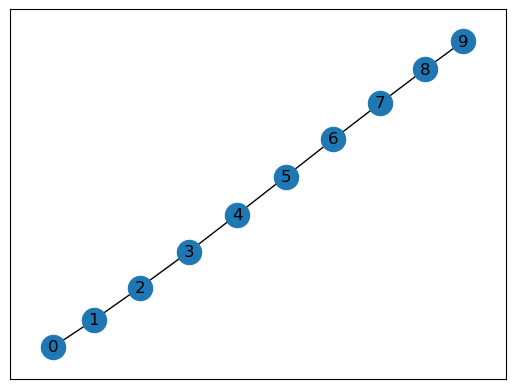

In [19]:
nx.draw_networkx(G)

In [20]:
P = nx.pagerank(G)
for key in P.keys():
    P[key] = round(P[key], 4)
P

{0: 0.0644,
 1: 0.1162,
 2: 0.1093,
 3: 0.1058,
 4: 0.1043,
 5: 0.1043,
 6: 0.1058,
 7: 0.1093,
 8: 0.1162,
 9: 0.0644}

In [21]:
Q, t = q_rank(G, .8)
Q

{0: 0.0804,
 1: 0.1102,
 2: 0.1051,
 3: 0.1027,
 4: 0.1017,
 5: 0.1017,
 6: 0.1027,
 7: 0.1051,
 8: 0.1102,
 9: 0.0804}

In [22]:
P1 = np.real(list(P.values()))
P1

array([0.0644, 0.1162, 0.1093, 0.1058, 0.1043, 0.1043, 0.1058, 0.1093,
       0.1162, 0.0644])

In [23]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0804, 0.1102, 0.1051, 0.1027, 0.1017, 0.1017, 0.1027, 0.1051,
       0.1102, 0.0804])

In [24]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

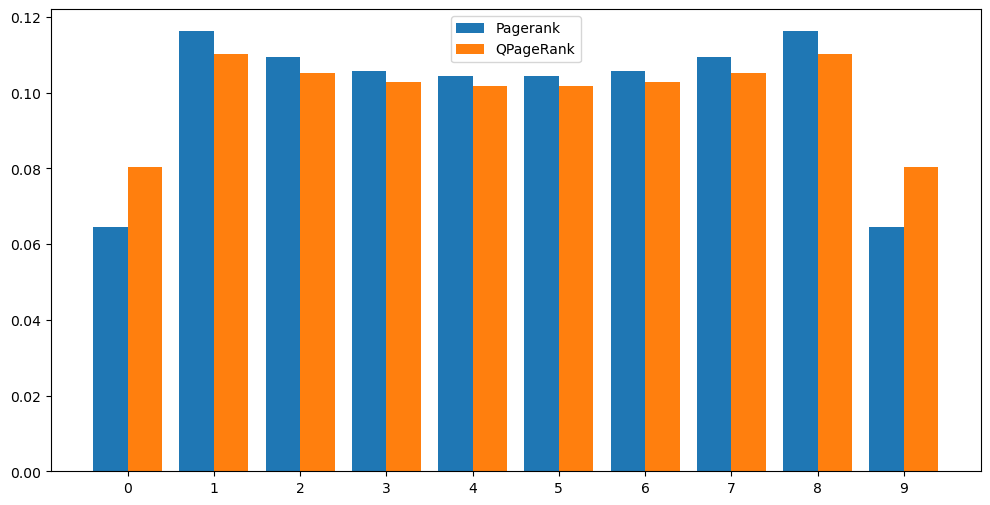

In [25]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [26]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 9, 1: 1, 2: 3, 3: 5, 4: 7, 5: 8, 6: 6, 7: 4, 8: 2, 9: 10}

In [27]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 9, 1: 1, 2: 3, 3: 5, 4: 7, 5: 8, 6: 6, 7: 4, 8: 2, 9: 10}

In [28]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [29]:
df["PageRanks"].corr(df["qPageRanks"])

0.9999999999999999

In [30]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0  1  2  3  4  5  6  7  8   9
PageRanks   9  1  3  5  7  8  6  4  2  10
qPageRanks  9  1  3  5  7  8  6  4  2  10


### Cycle graph

In [175]:
G = nx.cycle_graph(20)

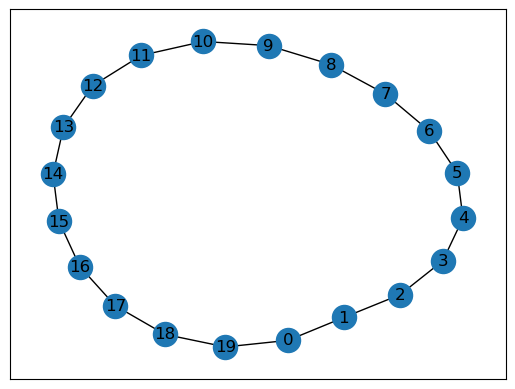

In [176]:
nx.draw_networkx(G)

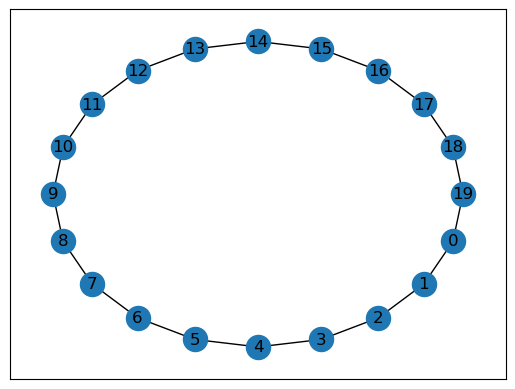

In [178]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

In [33]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [34]:
t

1

In [35]:
Q, t = q_rank(G, .8)
Q

{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [36]:
t

3

In [37]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [38]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [39]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

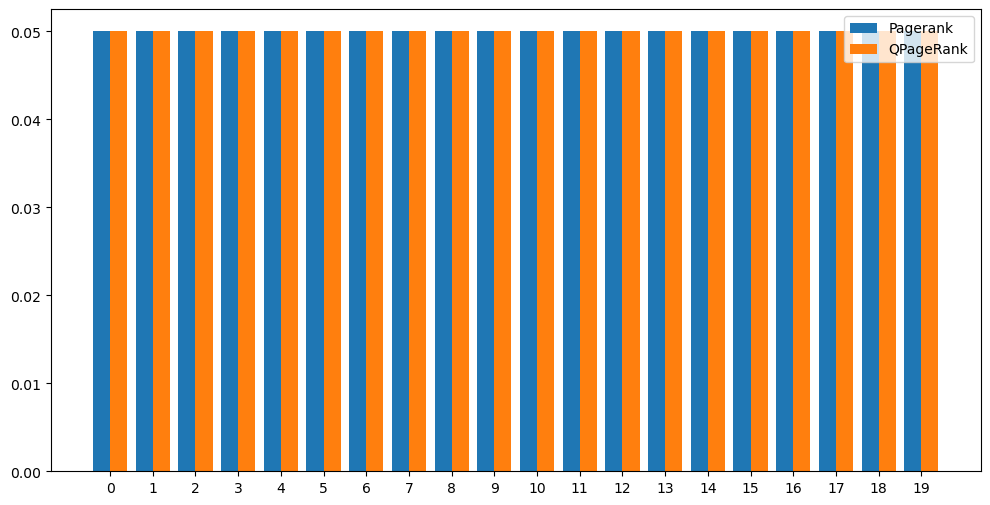

In [40]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [41]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [42]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [43]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [44]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [45]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   
qPageRanks   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   

            16  17  18  19  
PageRanks   17  18  19  20  
qPageRanks  17  18  19  20  


### Star graph

In [46]:
G = nx.star_graph(20)

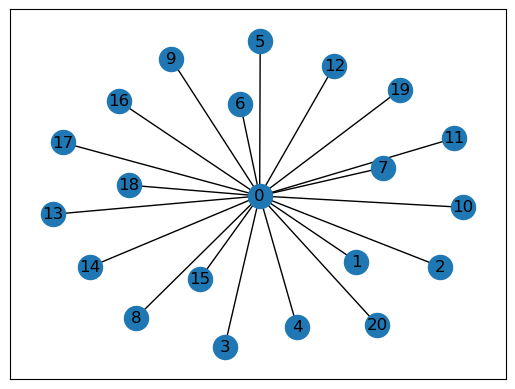

In [47]:
nx.draw_networkx(G)

In [48]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.4498,
 1: 0.0275,
 2: 0.0275,
 3: 0.0275,
 4: 0.0275,
 5: 0.0275,
 6: 0.0275,
 7: 0.0275,
 8: 0.0275,
 9: 0.0275,
 10: 0.0275,
 11: 0.0275,
 12: 0.0275,
 13: 0.0275,
 14: 0.0275,
 15: 0.0275,
 16: 0.0275,
 17: 0.0275,
 18: 0.0275,
 19: 0.0275,
 20: 0.0275}

In [49]:
t

41

In [50]:
Q, t = q_rank(G, .8)
Q

{0: 0.3121,
 1: 0.0344,
 2: 0.0344,
 3: 0.0344,
 4: 0.0344,
 5: 0.0344,
 6: 0.0344,
 7: 0.0344,
 8: 0.0344,
 9: 0.0344,
 10: 0.0344,
 11: 0.0344,
 12: 0.0344,
 13: 0.0344,
 14: 0.0344,
 15: 0.0344,
 16: 0.0344,
 17: 0.0344,
 18: 0.0344,
 19: 0.0344,
 20: 0.0344}

In [51]:
t

11

In [52]:
P1 = np.real(list(P.values()))
P1

array([0.4498, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275,
       0.0275, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275, 0.0275,
       0.0275, 0.0275, 0.0275, 0.0275, 0.0275])

In [53]:
Q1 = np.real(list(Q.values()))
Q1

array([0.3121, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344])

In [54]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

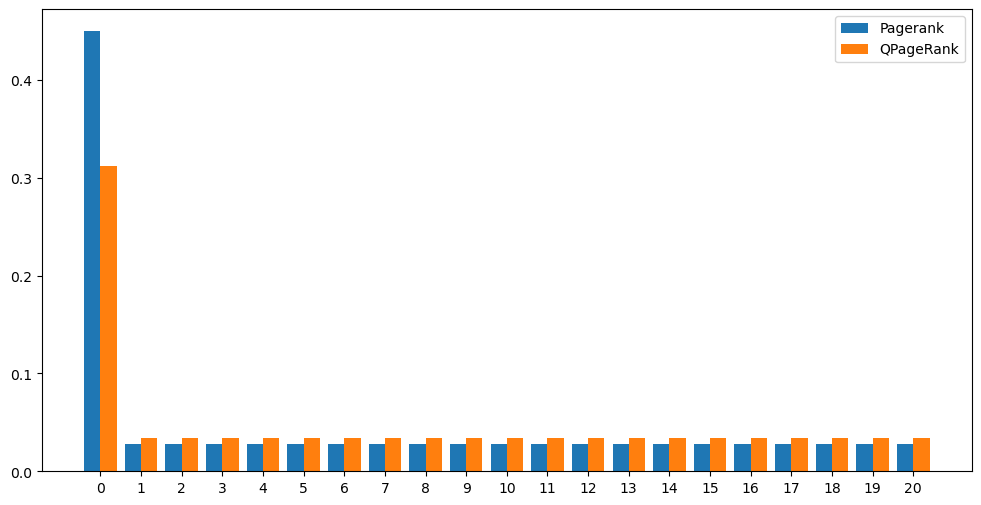

In [55]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [56]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21}

In [57]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21}

In [58]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [59]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [60]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   
qPageRanks   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   

            16  17  18  19  20  
PageRanks   17  18  19  20  21  
qPageRanks  17  18  19  20  21  


### Wheel graph

In [171]:
G = nx.wheel_graph(20)

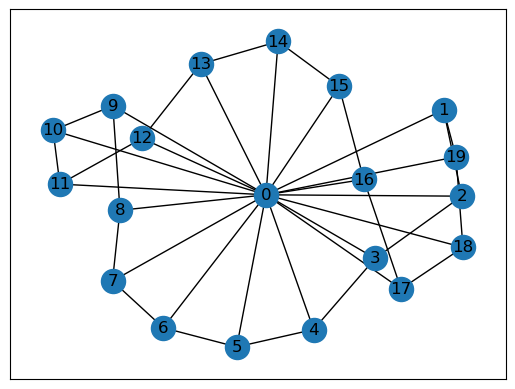

In [173]:
nx.draw_networkx(G)

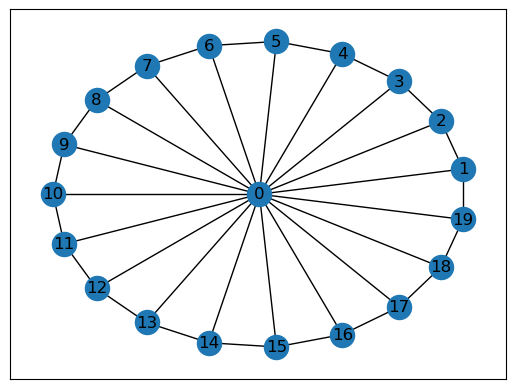

In [174]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [63]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.2184,
 1: 0.0411,
 2: 0.0411,
 3: 0.0411,
 4: 0.0411,
 5: 0.0411,
 6: 0.0411,
 7: 0.0411,
 8: 0.0411,
 9: 0.0411,
 10: 0.0411,
 11: 0.0411,
 12: 0.0411,
 13: 0.0411,
 14: 0.0411,
 15: 0.0411,
 16: 0.0411,
 17: 0.0411,
 18: 0.0411,
 19: 0.0411}

In [64]:
t

7

In [65]:
Q, t = q_rank(G, .8)
Q

{0: 0.188,
 1: 0.0427,
 2: 0.0427,
 3: 0.0427,
 4: 0.0427,
 5: 0.0427,
 6: 0.0427,
 7: 0.0427,
 8: 0.0427,
 9: 0.0427,
 10: 0.0427,
 11: 0.0427,
 12: 0.0427,
 13: 0.0427,
 14: 0.0427,
 15: 0.0427,
 16: 0.0427,
 17: 0.0427,
 18: 0.0427,
 19: 0.0427}

In [66]:
t

7

In [67]:
P1 = np.real(list(P.values()))
P1

array([0.2184, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411,
       0.0411, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411, 0.0411,
       0.0411, 0.0411, 0.0411, 0.0411])

In [68]:
Q1 = np.real(list(Q.values()))
Q1

array([0.188 , 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427])

In [69]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

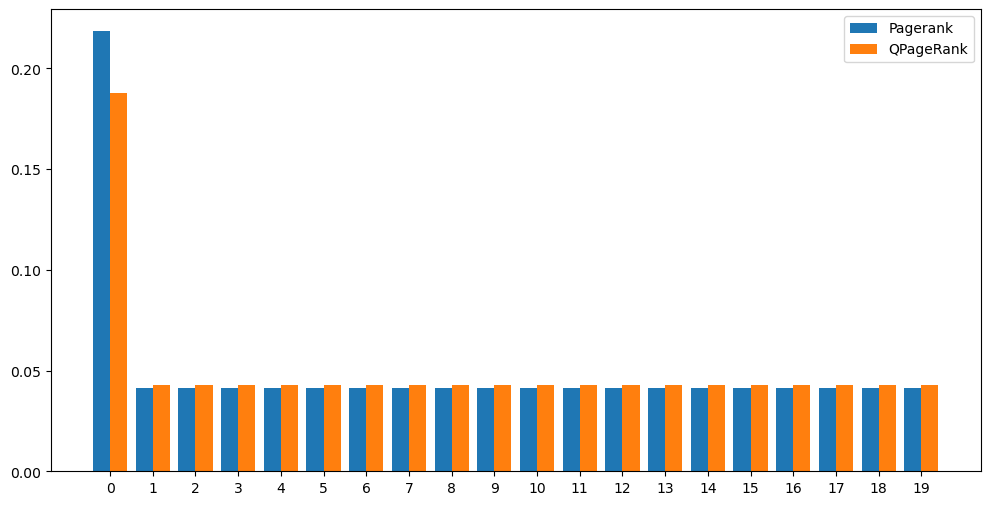

In [70]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [71]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [72]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [73]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [74]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [75]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   
qPageRanks   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   

            16  17  18  19  
PageRanks   17  18  19  20  
qPageRanks  17  18  19  20  


### Complete graph

In [76]:
G = nx.complete_graph(20)

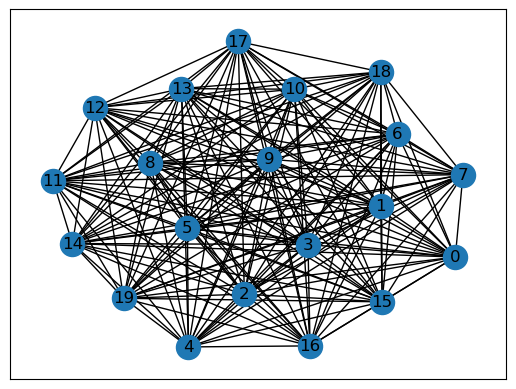

In [77]:
nx.draw_networkx(G)

In [78]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [79]:
t

1

In [80]:
Q, t = q_rank(G, .8)
Q

{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [81]:
t

3

In [82]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [83]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [84]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

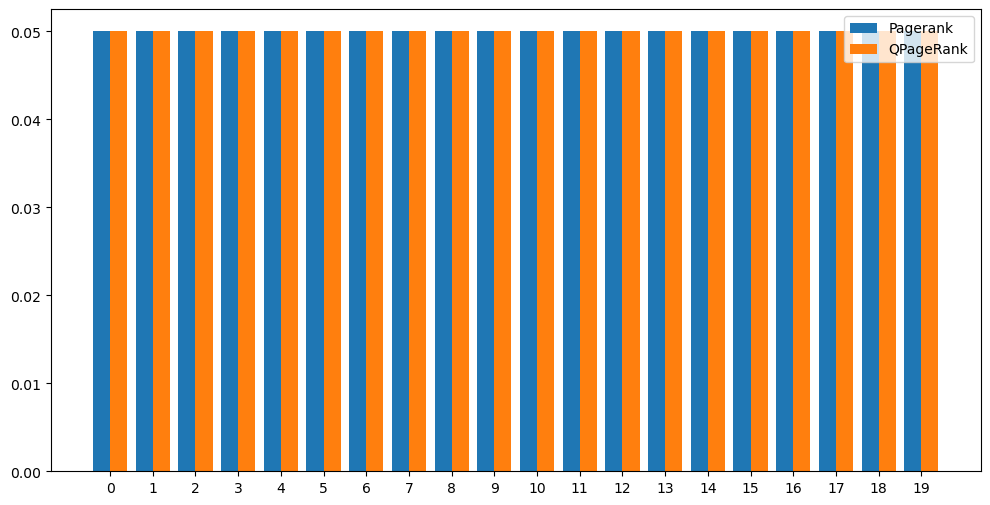

In [85]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [86]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [87]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20}

In [88]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [89]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [90]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   
qPageRanks   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16   

            16  17  18  19  
PageRanks   17  18  19  20  
qPageRanks  17  18  19  20  


### Balanced Tree

In [91]:
G = nx.balanced_tree(3,3)

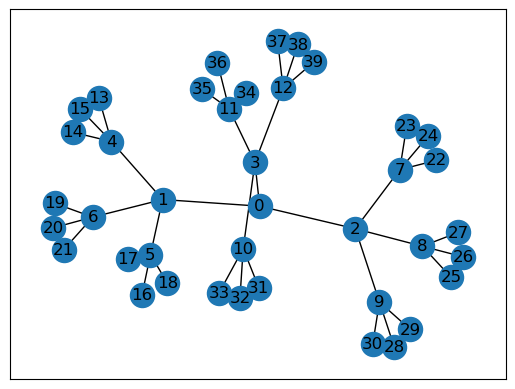

In [92]:
nx.draw_networkx(G)

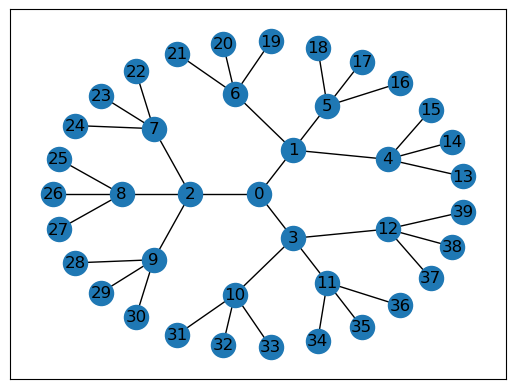

In [93]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [94]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.0305,
 1: 0.0426,
 2: 0.0426,
 3: 0.0426,
 4: 0.0491,
 5: 0.0491,
 6: 0.0491,
 7: 0.0491,
 8: 0.0491,
 9: 0.0491,
 10: 0.0491,
 11: 0.0491,
 12: 0.0491,
 13: 0.0148,
 14: 0.0148,
 15: 0.0148,
 16: 0.0148,
 17: 0.0148,
 18: 0.0148,
 19: 0.0148,
 20: 0.0148,
 21: 0.0148,
 22: 0.0148,
 23: 0.0148,
 24: 0.0148,
 25: 0.0148,
 26: 0.0148,
 27: 0.0148,
 28: 0.0148,
 29: 0.0148,
 30: 0.0148,
 31: 0.0148,
 32: 0.0148,
 33: 0.0148,
 34: 0.0148,
 35: 0.0148,
 36: 0.0148,
 37: 0.0148,
 38: 0.0148,
 39: 0.0148}

In [95]:
t

34

In [96]:
Q, t = q_rank(G, .8)
Q

{0: 0.0284,
 1: 0.0366,
 2: 0.0366,
 3: 0.0366,
 4: 0.0404,
 5: 0.0404,
 6: 0.0404,
 7: 0.0404,
 8: 0.0404,
 9: 0.0404,
 10: 0.0404,
 11: 0.0404,
 12: 0.0404,
 13: 0.0185,
 14: 0.0185,
 15: 0.0185,
 16: 0.0185,
 17: 0.0185,
 18: 0.0185,
 19: 0.0185,
 20: 0.0185,
 21: 0.0185,
 22: 0.0185,
 23: 0.0185,
 24: 0.0185,
 25: 0.0185,
 26: 0.0185,
 27: 0.0185,
 28: 0.0185,
 29: 0.0185,
 30: 0.0185,
 31: 0.0185,
 32: 0.0185,
 33: 0.0185,
 34: 0.0185,
 35: 0.0185,
 36: 0.0185,
 37: 0.0185,
 38: 0.0185,
 39: 0.0185}

In [97]:
t

10

In [98]:
P1 = np.real(list(P.values()))
P1

array([0.0305, 0.0426, 0.0426, 0.0426, 0.0491, 0.0491, 0.0491, 0.0491,
       0.0491, 0.0491, 0.0491, 0.0491, 0.0491, 0.0148, 0.0148, 0.0148,
       0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148,
       0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148,
       0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148, 0.0148])

In [99]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0284, 0.0366, 0.0366, 0.0366, 0.0404, 0.0404, 0.0404, 0.0404,
       0.0404, 0.0404, 0.0404, 0.0404, 0.0404, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [100]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

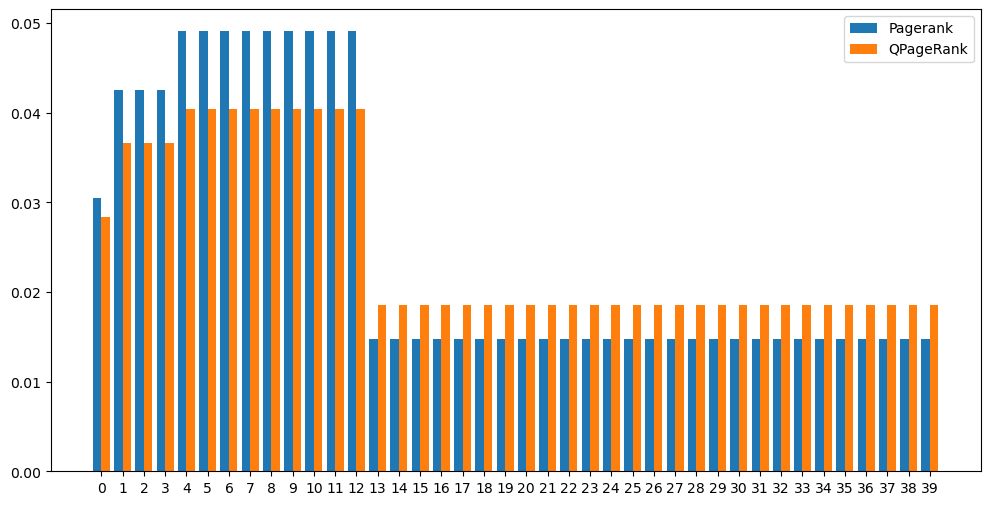

In [101]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [102]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 13,
 1: 10,
 2: 11,
 3: 12,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40}

In [103]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 13,
 1: 10,
 2: 11,
 3: 12,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40}

In [104]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [105]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [106]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks   13  10  11  12   1   2   3   4   5   6   7   8   9  14  15  16   
qPageRanks  13  10  11  12   1   2   3   4   5   6   7   8   9  14  15  16   

            16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
PageRanks   17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32   
qPageRanks  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32   

            32  33  34  35  36  37  38  39  
PageRanks   33  34  35  36  37  38  39  40  
qPageRanks  33  34  35  36  37  38  39  40  


### Barbell Graph

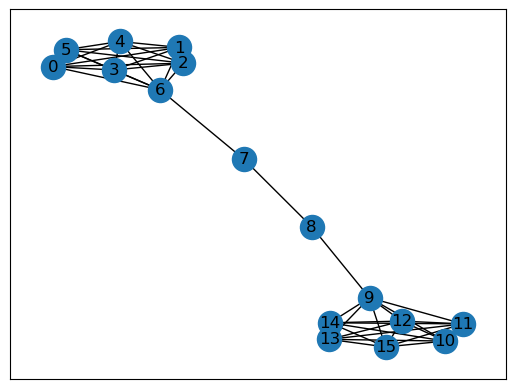

In [107]:
G = nx.barbell_graph(7,2)
nx.draw_networkx(G)

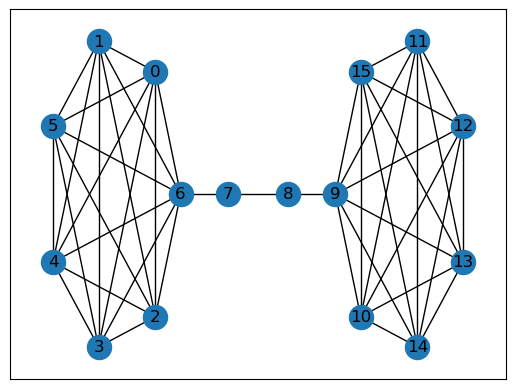

In [108]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our PageRank program fails to find the PageRank of the Barbell graph. We use the library function for calculating PageRank available in Networkx.

In [109]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.0643,
 1: 0.0643,
 2: 0.0643,
 3: 0.0643,
 4: 0.0643,
 5: 0.0643,
 6: 0.0783,
 7: 0.0358,
 8: 0.0358,
 9: 0.0783,
 10: 0.0643,
 11: 0.0643,
 12: 0.0643,
 13: 0.0643,
 14: 0.0643,
 15: 0.0643}

In [110]:
P = nx.pagerank(G)
P

{0: 0.06478714196346358,
 1: 0.06478714196346358,
 2: 0.06478714196346358,
 3: 0.06478714196346358,
 4: 0.06478714196346358,
 5: 0.06478714196346358,
 6: 0.07841212376187823,
 7: 0.032865024457340075,
 8: 0.032865024457340075,
 9: 0.07841212376187826,
 10: 0.06478714196346358,
 11: 0.06478714196346358,
 12: 0.06478714196346358,
 13: 0.06478714196346358,
 14: 0.06478714196346358,
 15: 0.06478714196346358}

In [111]:
P = dict(sorted(P.items()))
P

{0: 0.06478714196346358,
 1: 0.06478714196346358,
 2: 0.06478714196346358,
 3: 0.06478714196346358,
 4: 0.06478714196346358,
 5: 0.06478714196346358,
 6: 0.07841212376187823,
 7: 0.032865024457340075,
 8: 0.032865024457340075,
 9: 0.07841212376187826,
 10: 0.06478714196346358,
 11: 0.06478714196346358,
 12: 0.06478714196346358,
 13: 0.06478714196346358,
 14: 0.06478714196346358,
 15: 0.06478714196346358}

In [112]:
Q, t = q_rank(G, .8)
Q

{0: 0.0641,
 1: 0.0641,
 2: 0.0641,
 3: 0.0641,
 4: 0.0641,
 5: 0.0641,
 6: 0.0755,
 7: 0.0402,
 8: 0.0402,
 9: 0.0755,
 10: 0.0641,
 11: 0.0641,
 12: 0.0641,
 13: 0.0641,
 14: 0.0641,
 15: 0.0641}

In [113]:
t

13

In [114]:
P1 = np.real(list(P.values()))
P1

array([0.06478714, 0.06478714, 0.06478714, 0.06478714, 0.06478714,
       0.06478714, 0.07841212, 0.03286502, 0.03286502, 0.07841212,
       0.06478714, 0.06478714, 0.06478714, 0.06478714, 0.06478714,
       0.06478714])

In [115]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0755, 0.0402,
       0.0402, 0.0755, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641])

In [116]:
X = sorted(list(G.nodes()))
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

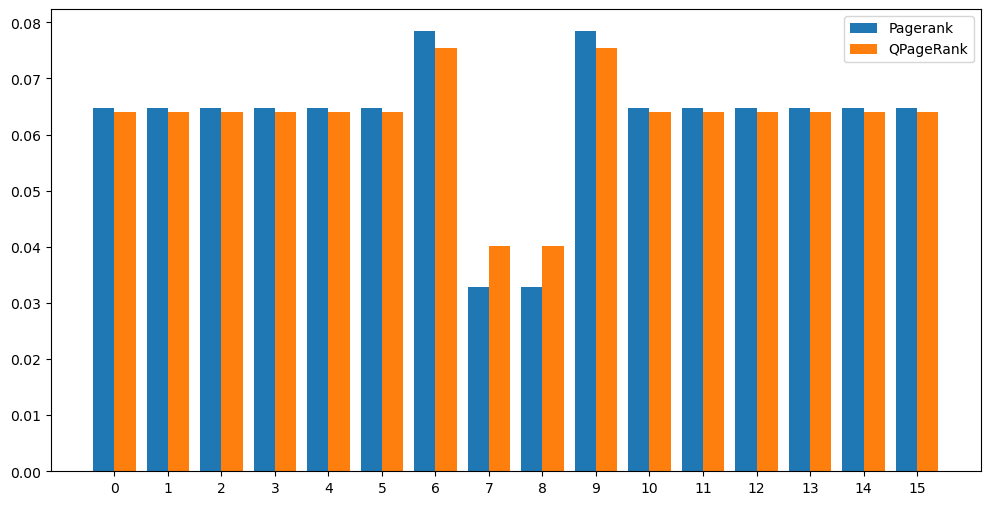

In [117]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [118]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 3,
 1: 4,
 2: 5,
 3: 6,
 4: 7,
 5: 8,
 6: 2,
 7: 15,
 8: 16,
 9: 1,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14}

In [119]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 3,
 1: 4,
 2: 5,
 3: 6,
 4: 7,
 5: 8,
 6: 1,
 7: 15,
 8: 16,
 9: 2,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14}

In [120]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [121]:
df["PageRanks"].corr(df["qPageRanks"])

0.9970588235294118

In [122]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
PageRanks    3   4   5   6   7   8   2  15  16   1   9  10  11  12  13  14
qPageRanks   3   4   5   6   7   8   1  15  16   2   9  10  11  12  13  14


### Watts-Strogatz model

Duncan J. Watts and Steven H. Strogatz, Collective dynamics of small-world networks, Nature, 393, pp. 440–442, 1998.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [187]:
H = nx.watts_strogatz_graph(20, 3, .3, seed=None)
H.remove_edges_from(nx.selfloop_edges(H))

In [189]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [190]:
E = list(H.edges())
E

[(0, 1),
 (0, 19),
 (1, 18),
 (2, 5),
 (2, 4),
 (3, 4),
 (5, 6),
 (6, 7),
 (6, 15),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 18),
 (11, 12),
 (12, 13),
 (13, 14),
 (13, 17),
 (14, 15),
 (16, 17),
 (17, 18)]

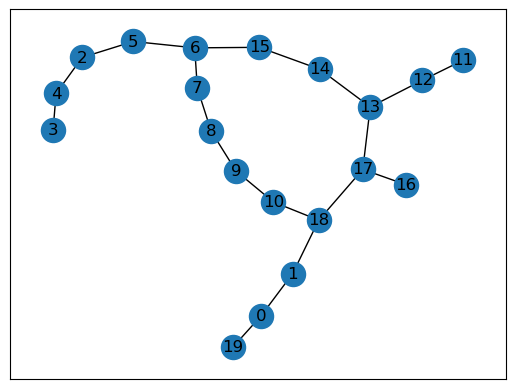

In [188]:
nx.draw_networkx(H)

In [191]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(0, 1), (0, 19), (1, 18), (2, 5), (2, 4), (3, 4), (5, 6), (6, 7), (6, 15), (7, 8), (8, 9), (9, 10), (10, 18),
 (11, 12), (12, 13),  (13, 14), (13, 17), (14, 15), (16, 17), (17, 18)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

In [192]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.0554,
 1: 0.0506,
 2: 0.0525,
 3: 0.0316,
 4: 0.0567,
 5: 0.0492,
 6: 0.0685,
 7: 0.0473,
 8: 0.0481,
 9: 0.0481,
 10: 0.0475,
 11: 0.0299,
 12: 0.0527,
 13: 0.0698,
 14: 0.0473,
 15: 0.047,
 16: 0.0274,
 17: 0.0701,
 18: 0.0691,
 19: 0.031}

In [193]:
t

25

In [194]:
Q, t = q_rank(G, .85)
Q

{0: 0.0536,
 1: 0.0499,
 2: 0.0514,
 3: 0.0399,
 4: 0.0545,
 5: 0.049,
 6: 0.0615,
 7: 0.0479,
 8: 0.0486,
 9: 0.0486,
 10: 0.0479,
 11: 0.0386,
 12: 0.0518,
 13: 0.0621,
 14: 0.0477,
 15: 0.0475,
 16: 0.0361,
 17: 0.0624,
 18: 0.0616,
 19: 0.0395}

In [195]:
t

15

In [196]:
P1 = np.real(list(P.values()))
P1

array([0.0554, 0.0506, 0.0525, 0.0316, 0.0567, 0.0492, 0.0685, 0.0473,
       0.0481, 0.0481, 0.0475, 0.0299, 0.0527, 0.0698, 0.0473, 0.047 ,
       0.0274, 0.0701, 0.0691, 0.031 ])

In [197]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0536, 0.0499, 0.0514, 0.0399, 0.0545, 0.049 , 0.0615, 0.0479,
       0.0486, 0.0486, 0.0479, 0.0386, 0.0518, 0.0621, 0.0477, 0.0475,
       0.0361, 0.0624, 0.0616, 0.0395])

In [198]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

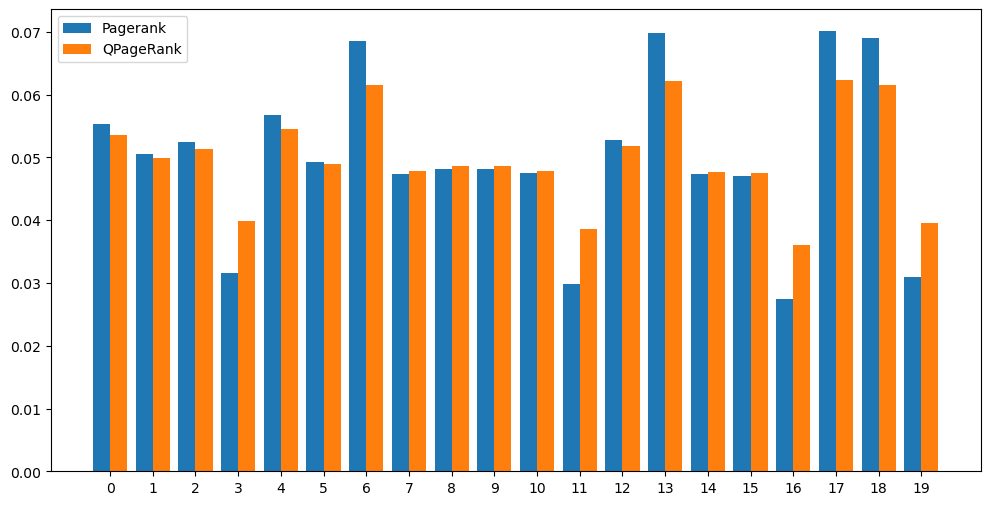

In [199]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [133]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 8,
 1: 9,
 2: 17,
 3: 6,
 4: 20,
 5: 4,
 6: 19,
 7: 3,
 8: 13,
 9: 15,
 10: 18,
 11: 2,
 12: 1,
 13: 14,
 14: 12,
 15: 11,
 16: 10,
 17: 16,
 18: 5,
 19: 7}

In [134]:
qPageRanks = find_ranks_of_vertices(P)
qPageRanks

{0: 8,
 1: 9,
 2: 17,
 3: 6,
 4: 20,
 5: 4,
 6: 19,
 7: 3,
 8: 13,
 9: 15,
 10: 18,
 11: 2,
 12: 1,
 13: 14,
 14: 12,
 15: 11,
 16: 10,
 17: 16,
 18: 5,
 19: 7}

In [135]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [136]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [137]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    8   9  17   6  20   4  19   3  13  15  18   2   1  14  12  11   
qPageRanks   8   9  17   6  20   4  19   3  13  15  18   2   1  14  12  11   

            16  17  18  19  
PageRanks   10  16   5   7  
qPageRanks  10  16   5   7  


### Karate Club

Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473.

https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html

In [138]:
G = nx.karate_club_graph()
# G.remove_edges_from(nx.selfloop_edges(G))

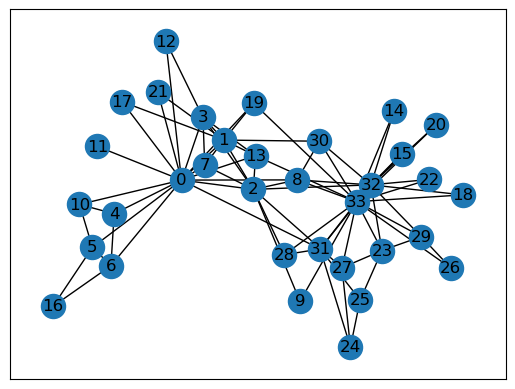

In [139]:
nx.draw_networkx(G)

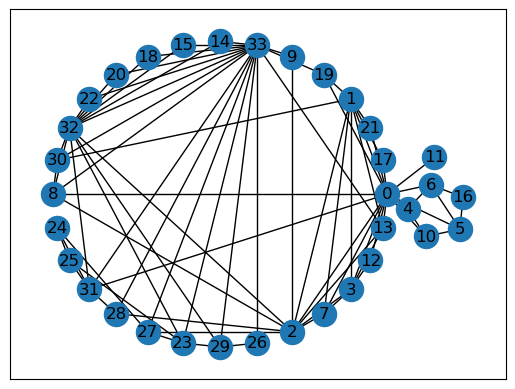

In [140]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [141]:
P= nx.pagerank(G, .85)
P

{0: 0.08850807396280012,
 1: 0.057414840497110056,
 2: 0.06276686454603017,
 3: 0.03721208153631377,
 4: 0.020503977347501652,
 5: 0.03381044255357727,
 6: 0.03152901134345504,
 7: 0.026464618678806107,
 8: 0.03338155566846444,
 9: 0.009463219565799959,
 10: 0.020689016083505596,
 11: 0.009785686547904305,
 12: 0.011474872305945287,
 13: 0.033474187085322404,
 14: 0.012941600888556285,
 15: 0.01637633262359366,
 16: 0.016755401561857987,
 17: 0.009677265915396801,
 18: 0.009544864590131914,
 19: 0.013077518431081969,
 20: 0.011224235021037596,
 21: 0.01136015256356328,
 22: 0.01296059860686279,
 23: 0.04114596964602211,
 24: 0.01663437445025268,
 25: 0.028672962013730707,
 26: 0.015240392773380823,
 27: 0.027235358397633882,
 28: 0.01447852177427162,
 29: 0.028271813832825125,
 30: 0.02303184425091186,
 31: 0.04198548926127872,
 32: 0.07592643687005646,
 33: 0.09698041880501741}

In [142]:
Q, t = q_rank(G, .85)
Q

{0: 0.0834,
 1: 0.0479,
 2: 0.0513,
 3: 0.0342,
 4: 0.0236,
 5: 0.0292,
 6: 0.0292,
 7: 0.025,
 8: 0.0292,
 9: 0.0174,
 10: 0.0236,
 11: 0.0149,
 12: 0.0178,
 13: 0.029,
 14: 0.0177,
 15: 0.0177,
 16: 0.02,
 17: 0.0177,
 18: 0.0177,
 19: 0.0213,
 20: 0.0177,
 21: 0.0177,
 22: 0.0177,
 23: 0.0308,
 24: 0.0228,
 25: 0.0228,
 26: 0.0182,
 27: 0.0261,
 28: 0.0213,
 29: 0.0267,
 30: 0.0251,
 31: 0.0353,
 32: 0.0632,
 33: 0.087}

In [143]:
t

15

In [144]:
P1 = np.real(list(P.values()))
P1

array([0.08850807, 0.05741484, 0.06276686, 0.03721208, 0.02050398,
       0.03381044, 0.03152901, 0.02646462, 0.03338156, 0.00946322,
       0.02068902, 0.00978569, 0.01147487, 0.03347419, 0.0129416 ,
       0.01637633, 0.0167554 , 0.00967727, 0.00954486, 0.01307752,
       0.01122424, 0.01136015, 0.0129606 , 0.04114597, 0.01663437,
       0.02867296, 0.01524039, 0.02723536, 0.01447852, 0.02827181,
       0.02303184, 0.04198549, 0.07592644, 0.09698042])

In [145]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0834, 0.0479, 0.0513, 0.0342, 0.0236, 0.0292, 0.0292, 0.025 ,
       0.0292, 0.0174, 0.0236, 0.0149, 0.0178, 0.029 , 0.0177, 0.0177,
       0.02  , 0.0177, 0.0177, 0.0213, 0.0177, 0.0177, 0.0177, 0.0308,
       0.0228, 0.0228, 0.0182, 0.0261, 0.0213, 0.0267, 0.0251, 0.0353,
       0.0632, 0.087 ])

In [146]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

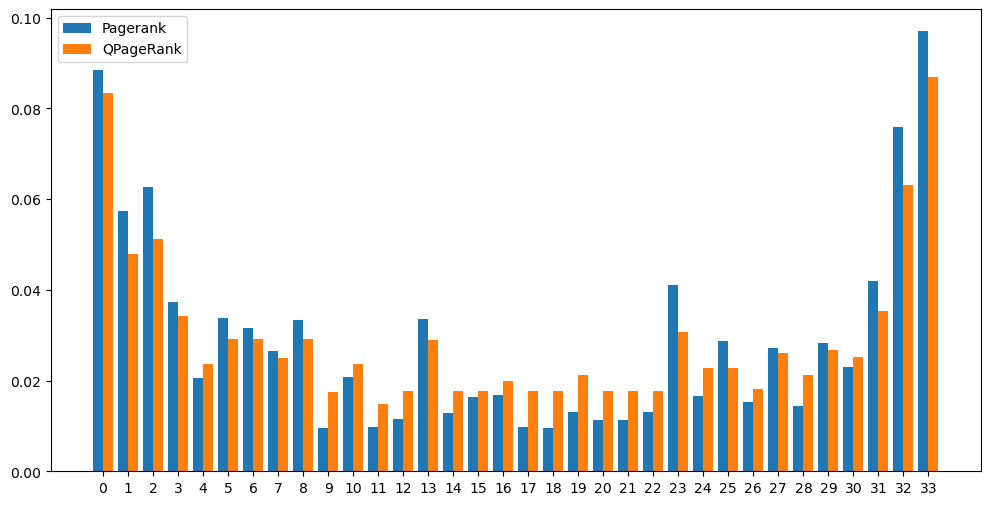

In [147]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [148]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 2,
 1: 5,
 2: 4,
 3: 8,
 4: 19,
 5: 9,
 6: 12,
 7: 16,
 8: 11,
 9: 34,
 10: 18,
 11: 31,
 12: 28,
 13: 10,
 14: 27,
 15: 22,
 16: 20,
 17: 32,
 18: 33,
 19: 25,
 20: 30,
 21: 29,
 22: 26,
 23: 7,
 24: 21,
 25: 13,
 26: 23,
 27: 15,
 28: 24,
 29: 14,
 30: 17,
 31: 6,
 32: 3,
 33: 1}

In [149]:
qPageRanks = find_ranks_of_vertices(P)
qPageRanks

{0: 2,
 1: 5,
 2: 4,
 3: 8,
 4: 19,
 5: 9,
 6: 12,
 7: 16,
 8: 11,
 9: 34,
 10: 18,
 11: 31,
 12: 28,
 13: 10,
 14: 27,
 15: 22,
 16: 20,
 17: 32,
 18: 33,
 19: 25,
 20: 30,
 21: 29,
 22: 26,
 23: 7,
 24: 21,
 25: 13,
 26: 23,
 27: 15,
 28: 24,
 29: 14,
 30: 17,
 31: 6,
 32: 3,
 33: 1}

In [150]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [151]:
df["PageRanks"].corr(df["qPageRanks"])

1.0

In [152]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    2   5   4   8  19   9  12  16  11  34  18  31  28  10  27  22   
qPageRanks   2   5   4   8  19   9  12  16  11  34  18  31  28  10  27  22   

            16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
PageRanks   20  32  33  25  30  29  26   7  21  13  23  15  24  14  17   6   
qPageRanks  20  32  33  25  30  29  26   7  21  13  23  15  24  14  17   6   

            32  33  
PageRanks    3   1  
qPageRanks   3   1  


### Barabási and Albert model

A. L. Barabási and R. Albert “Emergence of scaling in random networks”, Science 286, pp 509-512, 1999.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html

In [200]:
H = nx.barabasi_albert_graph(20, 3, seed=None, initial_graph=None)
# H.remove_edges_from(nx.selfloop_edges(H))

In [201]:
V = list(H.nodes())
V

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [202]:
E = list(H.edges())
E

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 13),
 (0, 16),
 (0, 18),
 (2, 4),
 (2, 6),
 (2, 7),
 (2, 14),
 (2, 16),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 13),
 (3, 17),
 (4, 5),
 (4, 7),
 (4, 12),
 (4, 16),
 (4, 19),
 (5, 7),
 (5, 14),
 (5, 17),
 (6, 8),
 (6, 10),
 (6, 11),
 (6, 15),
 (6, 18),
 (7, 8),
 (7, 9),
 (7, 14),
 (7, 17),
 (7, 18),
 (7, 19),
 (9, 12),
 (9, 15),
 (10, 12),
 (10, 13),
 (10, 15),
 (18, 19)]

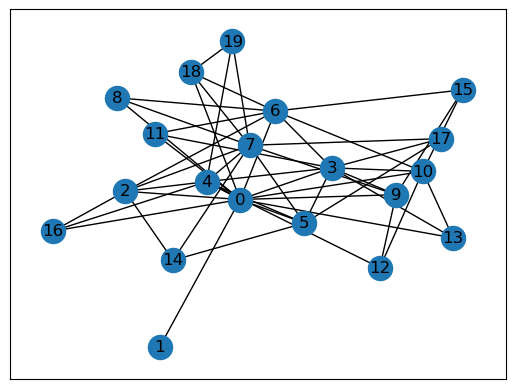

In [203]:
nx.draw_networkx(H)

In [204]:
V = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (0, 10), (0, 11), (0, 13), (0, 16), (0, 18),
 (2, 4), (2, 6), (2, 7), (2, 14), (2, 16), (3, 4), (3, 5), (3, 6), (3, 9), (3, 10), (3, 11), (3, 13), (3, 17),
 (4, 5), (4, 7), (4, 12), (4, 16), (4, 19), (5, 7), (5, 14), (5, 17), (6, 8), (6, 10), (6, 11), (6, 15), (6, 18),
 (7, 8), (7, 9), (7, 14), (7, 17), (7, 18), (7, 19), (9, 12), (9, 15), (10, 12), (10, 13), (10, 15), (18, 19)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

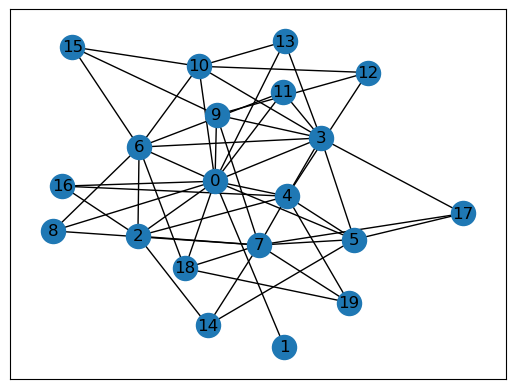

In [205]:
nx.draw_networkx(G)

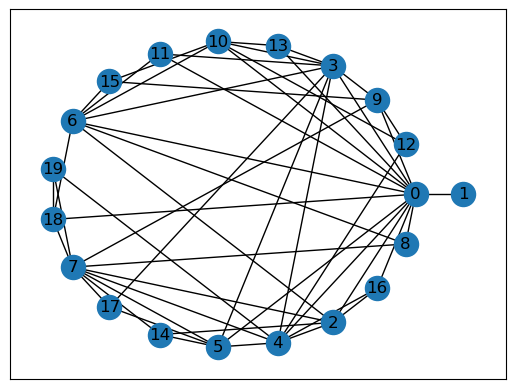

In [206]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [207]:
(P, t) = page_rank(G, .85)
P

/tmp/ipykernel_56686/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.1213,
 1: 0.0154,
 2: 0.0571,
 3: 0.0827,
 4: 0.0744,
 5: 0.0569,
 6: 0.075,
 7: 0.0843,
 8: 0.0314,
 9: 0.0494,
 10: 0.0583,
 11: 0.0312,
 12: 0.0321,
 13: 0.0315,
 14: 0.0316,
 15: 0.0321,
 16: 0.0314,
 17: 0.0313,
 18: 0.0404,
 19: 0.032}

In [208]:
Q, t = q_rank(G, .85)
Q

{0: 0.1081,
 1: 0.0245,
 2: 0.0554,
 3: 0.0764,
 4: 0.0696,
 5: 0.0553,
 6: 0.0702,
 7: 0.0779,
 8: 0.0347,
 9: 0.0492,
 10: 0.0565,
 11: 0.0345,
 12: 0.0354,
 13: 0.0348,
 14: 0.035,
 15: 0.0355,
 16: 0.0348,
 17: 0.0347,
 18: 0.042,
 19: 0.0353}

In [209]:
t

10

In [210]:
P1 = np.real(list(P.values()))
P1

array([0.1213, 0.0154, 0.0571, 0.0827, 0.0744, 0.0569, 0.075 , 0.0843,
       0.0314, 0.0494, 0.0583, 0.0312, 0.0321, 0.0315, 0.0316, 0.0321,
       0.0314, 0.0313, 0.0404, 0.032 ])

In [211]:
Q1 = np.real(list(Q.values()))
Q1

array([0.1081, 0.0245, 0.0554, 0.0764, 0.0696, 0.0553, 0.0702, 0.0779,
       0.0347, 0.0492, 0.0565, 0.0345, 0.0354, 0.0348, 0.035 , 0.0355,
       0.0348, 0.0347, 0.042 , 0.0353])

In [212]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

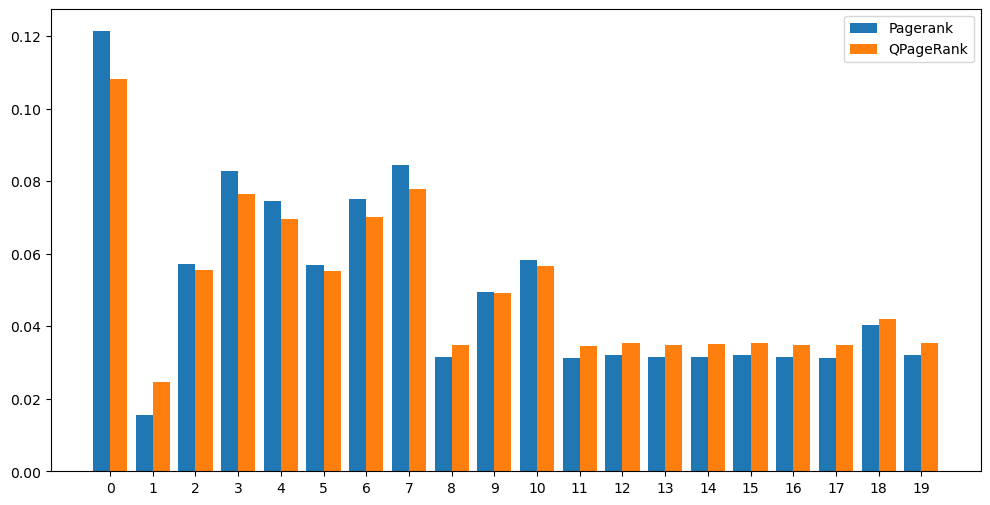

In [213]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'Pagerank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'QPageRank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

In [214]:
PageRanks = find_ranks_of_vertices(P)
PageRanks

{0: 1,
 1: 20,
 2: 7,
 3: 3,
 4: 5,
 5: 8,
 6: 4,
 7: 2,
 8: 16,
 9: 9,
 10: 6,
 11: 19,
 12: 11,
 13: 15,
 14: 14,
 15: 12,
 16: 17,
 17: 18,
 18: 10,
 19: 13}

In [215]:
qPageRanks = find_ranks_of_vertices(Q)
qPageRanks

{0: 1,
 1: 20,
 2: 7,
 3: 3,
 4: 5,
 5: 8,
 6: 4,
 7: 2,
 8: 17,
 9: 9,
 10: 6,
 11: 19,
 12: 12,
 13: 15,
 14: 14,
 15: 11,
 16: 16,
 17: 18,
 18: 10,
 19: 13}

In [216]:
df = pd.DataFrame([PageRanks, qPageRanks]).T
df.columns = ["PageRanks", "qPageRanks"]

In [217]:
df["PageRanks"].corr(df["qPageRanks"])

0.9969924812030074

In [218]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df.T)

            0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
PageRanks    1  20   7   3   5   8   4   2  16   9   6  19  11  15  14  12   
qPageRanks   1  20   7   3   5   8   4   2  17   9   6  19  12  15  14  11   

            16  17  18  19  
PageRanks   17  18  10  13  
qPageRanks  16  18  10  13  
